**временные ряды и модели ARIMA**

Евгений Борисов <esborisov@sevsu.ru>

-----

Дмитрий Макаров   Временные ряды.    
https://www.dmitrymakarov.ru/intro/time-series-20/

Евгений Рябенко Прогнозирование временных рядов.     
https://www.youtube.com/watch?v=u433nrxdf5k

-----

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%precision 3
np.set_printoptions(precision=2)
np.set_printoptions(linewidth=110)
# np.get_printoptions()

# загружаем данные

AirPassengers.csv

https://drive.google.com/file/d/1yfw6gcgmJXCtxkjC69ekUvsEtAiYTlST/view?usp=share_link

https://huggingface.co/spaces/Anniek/Time_series_forecast/raw/main/AirPassengers.csv

In [3]:
# читаем данные
url = 'https://huggingface.co/spaces/Anniek/Time_series_forecast/raw/main/AirPassengers.csv'
df = pd.read_csv(url).convert_dtypes()
display(df.info())
display(df.describe().T)
display(df.sample(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    string
 1   #Passengers  144 non-null    Int64 
dtypes: Int64(1), string(1)
memory usage: 2.5 KB


None

,count,mean,std,min,25%,50%,75%,max
#Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


,Month,#Passengers
101,1957-06,422
40,1952-05,183
77,1955-06,315


In [4]:
df['ts'] = pd.to_datetime(df['Month'])
df = df.set_index('ts')
df = df[['#Passengers']]
display(df.sample(3))

,#Passengers
ts,
1953-08-01,272
1953-04-01,235
1949-01-01,112


# анализ данных

__1. визуальная оценка данных__

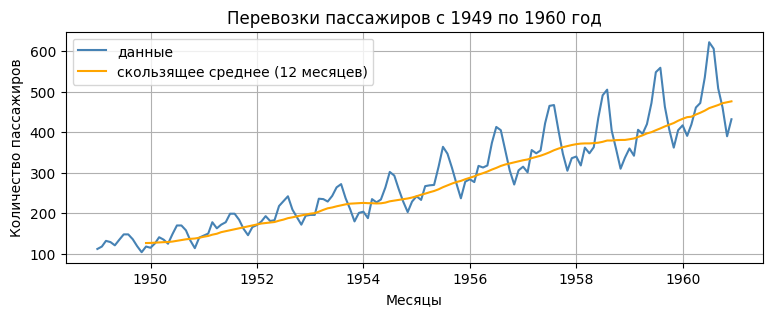

In [5]:
fig,ax = plt.subplots(figsize = (9,3))
ax.plot(df['#Passengers'], label = 'данные', color = 'steelblue')
ax.plot(df['#Passengers'].rolling(window=12).mean(), label = 'скользящее среднее (12 месяцев)', color = 'orange')
ax.set_xlabel('Месяцы', )
ax.set_ylabel('Количество пассажиров',)
ax.set_title('Перевозки пассажиров с 1949 по 1960 год', )
ax.legend(title = '', loc = 'upper left', )
ax.grid()

__оценка автокорреляции__

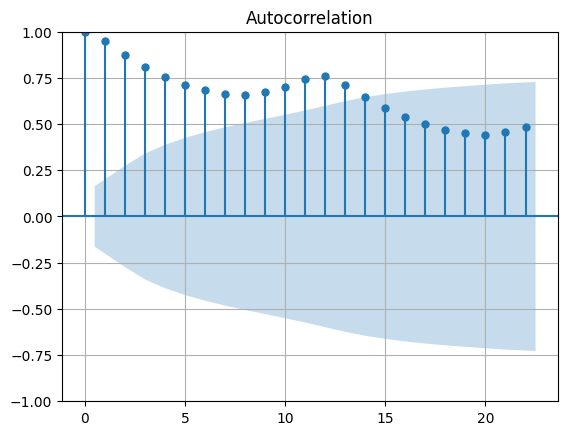

In [6]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['#Passengers'])
plt.grid()
plt.show()

__2. стабилизируем дисперсию (Бокс-Кокс)__

In [7]:
from scipy.special import boxcox

df['bcx'] = boxcox( df['#Passengers'],0 )

# from scipy.special import inv_boxcox
# df['bcx_inv'] = inv_boxcox(df['bcx'],0)

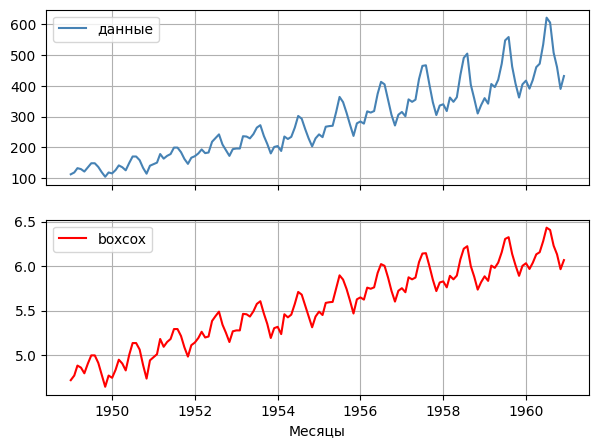

In [8]:
fig,ax = plt.subplots(2,1, figsize = (7,5),sharex=True)
ax[0].plot(df['#Passengers'], label = 'данные', color = 'steelblue')
ax[0].legend(title = '', loc = 'upper left', )
ax[0].grid()

ax[1].plot(df['bcx'], label = 'boxcox', color = 'red')
ax[1].legend(title = '', loc = 'upper left', )
ax[1].set_xlabel('Месяцы', )
ax[1].grid()

__оценка сезонности__

In [9]:
# !pip install statsmodels

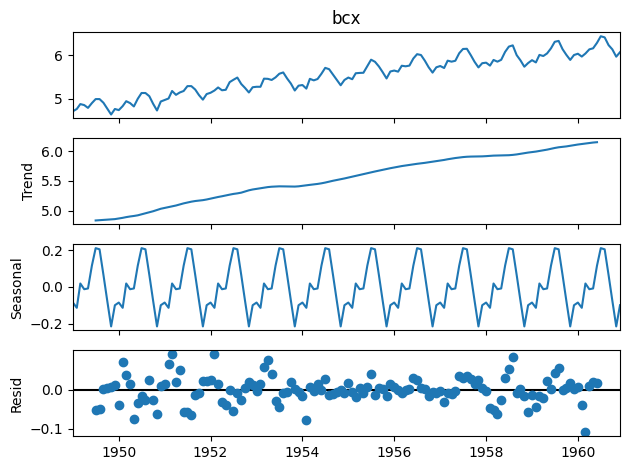

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(df['bcx'])
decompose.plot()
plt.show()

In [11]:
S = 12

__3. преобразуем ряд в стационарный__

подбираем порядок дифференцирования d,D (критерий Дики-Фуллера)

In [12]:
# Проверка временного ряда на стационарность
#     тест Дики-Фуллера (Dickey-Fuller test)
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df['bcx'])
print('p-value = ' + str(adf_test[1]))

p-value = 0.4223667747703874


__параметры d,D (количество дифференцирований)__

выбираем минимально необходимое для стационарности ряда

In [13]:
# дифференцирование
df['dif'] = df['bcx'].diff()#.diff().diff()
df['dif_s'] = df['bcx'].diff(periods=S)

In [14]:
adf_test = adfuller(df['dif'].fillna(0.))
print('p-value = ' + str(adf_test[1]))

p-value = 0.07859381719564043


In [15]:
adf_test = adfuller(df['dif_s'].fillna(0.))
print('p-value = ' + str(adf_test[1]))

p-value = 0.009417182340649867


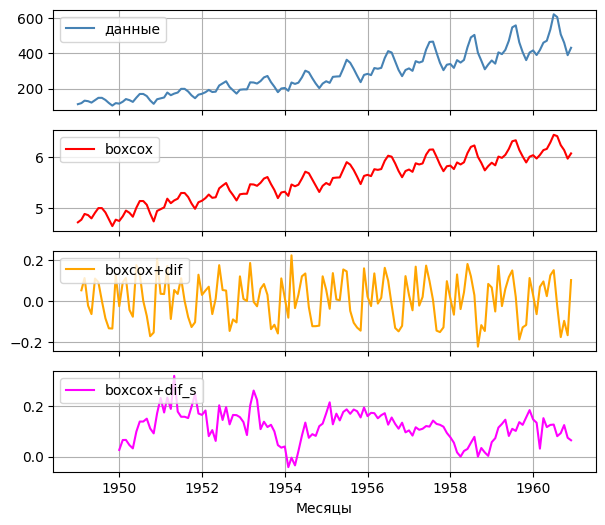

In [16]:
fig,ax = plt.subplots(4,1, figsize = (7,6),sharex=True)
ax[0].plot(df['#Passengers'], label = 'данные', color = 'steelblue')
ax[0].legend(title = '', loc = 'upper left', )
ax[0].grid()

ax[1].plot(df['bcx'], label = 'boxcox', color = 'red')
ax[1].legend(title = '', loc = 'upper left', )
ax[1].grid()

ax[2].plot(df['dif'], label = 'boxcox+dif', color = 'orange')
ax[2].legend(title = '', loc = 'upper left', )
ax[2].grid()

ax[3].plot(df['dif_s'], label = 'boxcox+dif_s', color = 'magenta')
ax[3].legend(title = '', loc = 'upper left', )
ax[3].set_xlabel('Месяцы', )
ax[3].grid()

In [17]:
d,D = 1,1

__3. анализируем автокорреляции__

подбираем p,q и P,Q

__строим график автокорреляции__   
q - номер последнего НЕсезонного лага, при котором автокорреляция значима, но меньше длинны сезона ;    
Q - номер последнего сезонного лага, при котором автокорреляция значима ;

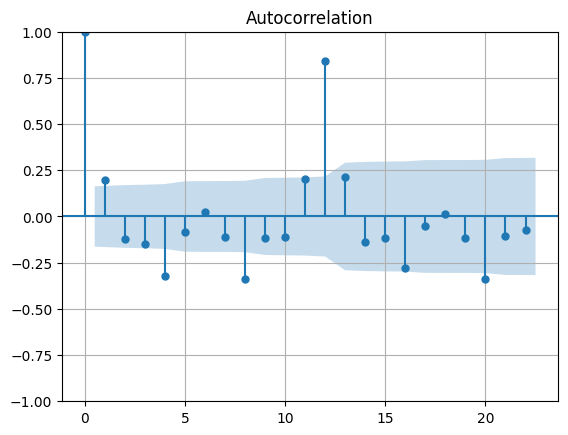

In [18]:
from statsmodels.graphics.tsaplots import plot_acf
#plot_acf(df['#Passengers'])
#plot_acf(df['bcx'])
plot_acf(df['dif'].fillna(0.))
plt.grid()
plt.show()

In [19]:
q,Q = 8,1

__строим график частичной автокорреляции__    
p - номер последнего НЕсезонного лага, при котором автокорреляция значима, но меньше длинны сезона ;   
P - номер последнего сезонного лага, при котором автокорреляция значима ;   

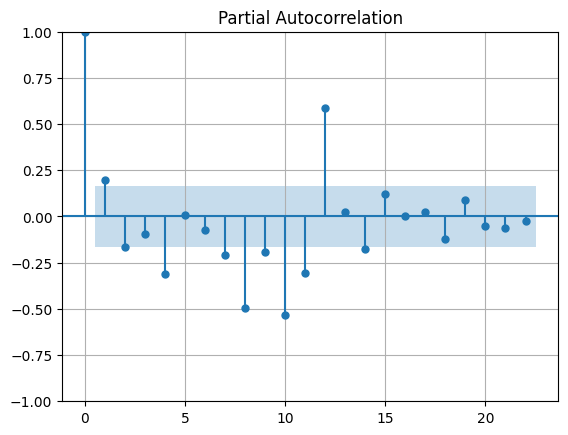

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf
#plot_pacf(df['#Passengers'])
# plot_pacf(df['bcx'])
plot_pacf(df['dif'].fillna(0.))
plt.grid()
plt.show()

In [21]:
p,P = 11,1

# модель

In [22]:
df.index = pd.DatetimeIndex(df.index.values, freq=df.index.inferred_freq)

# разобьём данные на обучающую и тестовую выборки

# обучающая выборка будет включать данные до декабря 1959 года включительно
train = df[:'1959-12']

# тестовая выборка начнется с января 1960 года (по сути, один год)
test = df['1960-01':]

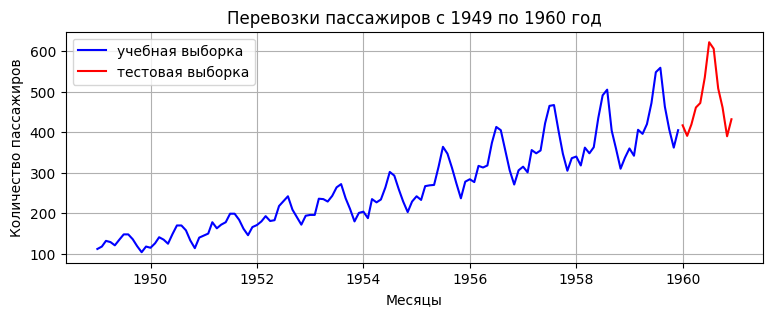

In [23]:
fig,ax = plt.subplots(figsize = (9,3))
ax.plot(train['#Passengers'], color = 'blue',label='учебная выборка')
ax.plot(test['#Passengers'], color = 'red',label='тестовая выборка')
ax.set_xlabel('Месяцы', )
ax.set_ylabel('Количество пассажиров',)
ax.set_title('Перевозки пассажиров с 1949 по 1960 год', )
ax.legend(title = '', loc = 'upper left', )
ax.grid()

In [24]:
%%time 

from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMAX (p,d,q),(P,D,Q)

model = SARIMAX(
        train['bcx'], 
        order = (p, d, q),
        seasonal_order = (P, D, Q, S)
    ).fit() 

/opt/venv/sevgu_1/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.39029D+00    |proj g|=  2.20058D+01

At iterate    5    f= -1.49282D+00    |proj g|=  3.39946D-01

At iterate   10    f= -1.59011D+00    |proj g|=  1.16191D+00

At iterate   15    f= -1.60326D+00    |proj g|=  2.92467D+00

At iterate   20    f= -1.68261D+00    |proj g|=  5.21982D-01

At iterate   25    f= -1.72166D+00    |proj g|=  1.25529D+00

At iterate   30    f= -1.72699D+00    |proj g|=  1.16598D+00

At iterate   35    f= -1.73239D+00    |proj g|=  8.39542D-02

At iterate   40    f= -1.73473D+00    |proj g|=  6.28102D-01

At iterate   45    f= -1.73650D+00    |proj g|=  9.06689D-01

At iterate   50    f= -1.73783D+00    |proj g|=  7.74611D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/venv/sevgu_1/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [25]:
# мы можем посмотреть результат с помощью метода summary()
print(model.summary())

                                       SARIMAX Results                                       
Dep. Variable:                                   bcx   No. Observations:                  132
Model:             SARIMAX(11, 1, 8)x(1, 1, [1], 12)   Log Likelihood                 229.393
Date:                               Wed, 24 Apr 2024   AIC                           -414.786
Time:                                       14:21:27   BIC                           -353.646
Sample:                                   01-01-1949   HQIC                          -389.959
                                        - 12-01-1959                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0048      0.897      0.005      0.996      -1.753       1.763
ar.L2      

# тестируем

In [26]:
from scipy.special import inv_boxcox

start,end  = len(train), len(train)+len(test)-1

# - выполняем обратные преобразования (дифференцирование,логарифмирование) для выдачи прогноза
predicted = inv_boxcox( model.predict(start, end), 0 )

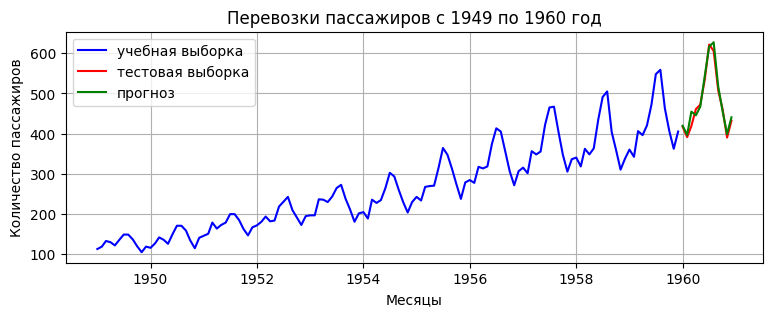

In [27]:
fig,ax = plt.subplots(figsize = (9,3))
ax.plot(train['#Passengers'], color = 'blue',label='учебная выборка')
ax.plot(test['#Passengers'], color = 'red',label='тестовая выборка')
ax.plot(predicted, color = 'green',  label='прогноз')

ax.set_xlabel('Месяцы', )
ax.set_ylabel('Количество пассажиров',)
ax.set_title('Перевозки пассажиров с 1949 по 1960 год', )
ax.legend(title = '', loc = 'upper left', )
ax.grid()

__оцениваем остатки (разница между прогнозом и тестовыми данными)__

In [28]:
from scipy.special import inv_boxcox

start,end  = 0, len(df)
predicted = inv_boxcox( model.predict(start, end), 0 )

In [29]:
err = df['#Passengers'] - predicted

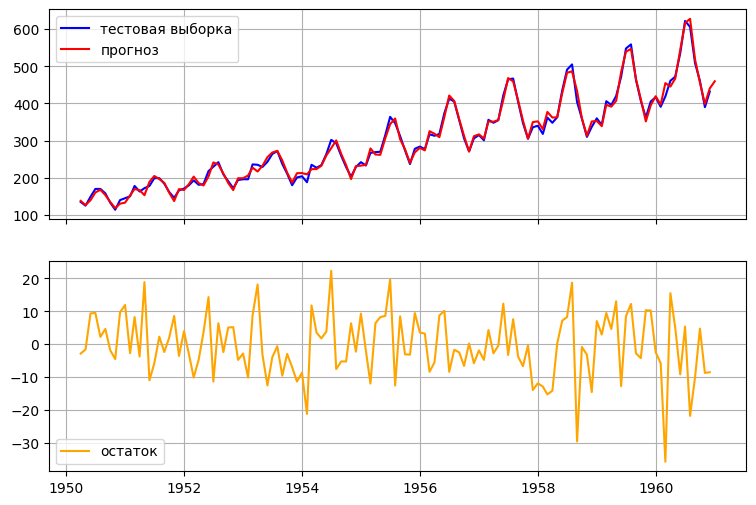

In [30]:
fig,ax = plt.subplots(2,1,figsize = (9,6),sharex=True)
ax[0].plot(df[15:]['#Passengers'], color = 'blue',label='тестовая выборка')
ax[0].plot(predicted[15:], color = 'red',label='прогноз')
ax[0].grid()
ax[0].legend()
ax[1].plot(err[15:], color = 'orange',label='остаток')
ax[1].grid()
ax[1].legend()

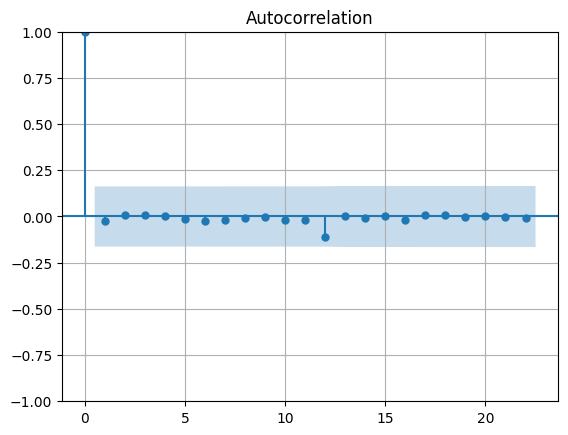

In [31]:
# оценка автокореляции остатков

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(err.fillna(0.))
plt.grid()
plt.show()

---

In [32]:
# построим прогноз на три года вперед
start, end = len(train), (len(df)-1)+3*12
predicted = inv_boxcox( model.predict(start, end), 0 )

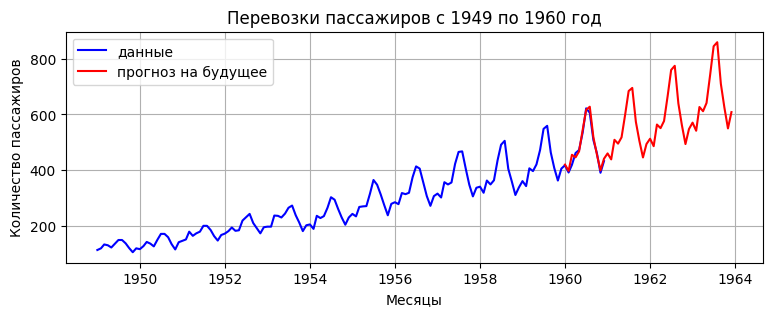

In [33]:
fig,ax = plt.subplots(figsize = (9,3))
ax.plot(df['#Passengers'], color = 'blue',label='данные')
ax.plot(predicted, color = 'red',label='прогноз на будущее')
ax.set_xlabel('Месяцы', )
ax.set_ylabel('Количество пассажиров',)
ax.set_title('Перевозки пассажиров с 1949 по 1960 год', )
ax.legend(title = '', loc = 'upper left', )
ax.grid()